In [1]:
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '' 
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'

In [2]:
import os
import torch
import pytorch_lightning as pl
import numpy as np
import json
import cv2

# from nomeroff_net.data_loaders.text_image_generator import TextImageGenerator
# from nomeroff_net.data_modules.numberplate_ocr_data_module import OcrNetDataModule
# from nomeroff_net.nnmodels.ocr_model import NPOcrNet
# from nomeroff_net.tools.ocr_tools import StrLabelConverter
# from nomeroff_net.tools.image_processing import normalize_img

from npocrnet import NPOcrNet


from itertools import islice
from PIL import Image


/home/worker/.local/lib/python3.9/site-packages/pkg_resources/__init__.py:116: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
letters = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "E", "H", "K", "M", "O",
               "P", "T", "X", "Y"]

In [4]:
model = NPOcrNet(letters_max=23)
model.load_state_dict(torch.load('anpr_ocr_ru_2022_03_28_pytorch_lightning.ckpt')['state_dict'])
model.eval()

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /home/worker/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

NPOcrNet(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

In [43]:
pred = model(batch[0].unsqueeze(0))

**Пробую получать предсказания через класс OCR:**

In [84]:
import os
import sys
import torch
import warnings
from matplotlib import pyplot as plt
from datetime import datetime
warnings.filterwarnings('ignore')

# change this property
NOMEROFF_NET_DIR = os.path.abspath('../../../../')
sys.path.append(NOMEROFF_NET_DIR)

from nomeroff_net.text_detectors.base.ocr import OCR

In [109]:
train_image_generator = TextImageGenerator(
            dirpath='data/data/autoriaNumberplateOcrRu-2021-09-01/train/',
            letters=letters,
            max_text_len=9,
            img_w=128,
            img_h=64,
            batch_size=8,
            max_plate_length=9,
            with_aug=False)

batch = iter(train_image_generator)
from itertools import islice
batch_ = next(islice(batch, 1, None))
input = batch_[0].unsqueeze(0)

100%|██████████| 49382/49382 [00:02<00:00, 22395.77it/s]

len of train dataset: 49382


In [143]:
batch_[0].permute(1, 2, 0).numpy().shape

(64, 128, 3)

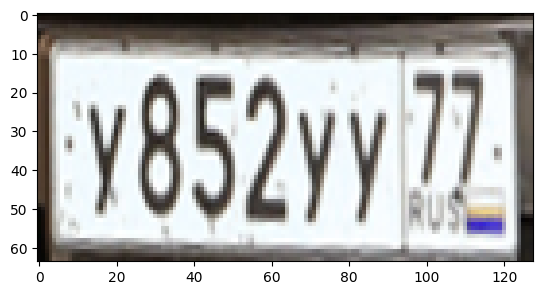

In [145]:
plt.imshow(batch_[0].permute(1, 2, 0).numpy())

In [152]:
print('prediction:', ocrTextDetector.predict(batch_[0].unsqueeze(0).to('cuda'))[0])
print('real:', batch_[1])

prediction: A592Y7
real: y852yy77


In [119]:
class ru(OCR):
    def __init__(self):
        OCR.__init__(self)
        self.letters = ["0", "1", "2", "3", "4", "5", "6", "7", "8", "9", "A", "B", "C", "E", "H", "K", "M", "O",
                        "P", "T", "X", "Y"]
        self.max_text_len = 9
        self.max_plate_length = 9
        self.letters_max = len(self.letters)+1
        self.init_label_converter()

In [120]:
ocrTextDetector = ru()
ocrTextDetector.model = ocrTextDetector.load_model('anpr_ocr_ru_2022_03_28_pytorch_lightning.ckpt')

In [ ]:
batch = iter(train_image_generator)
for i in range(10):
    batch_ = next(islice(batch, 1, None))
    input = batch_[0].unsqueeze(0)
    print('prediction:', ocrTextDetector.predict(input.to('cuda'))[0])
    print('real:', batch_[1])
    print()

In [122]:
preds = []
batch = iter(train_image_generator)
for i in range(10):
    batch_ = next(islice(batch, 1, None))
    input = batch_[0].unsqueeze(0)
    preds.append(ocrTextDetector.forward(input.to('cuda')))

In [166]:
image_path = 'data/data/autoriaNumberplateOcrRu-2021-09-01/train/img/1_11_2014_12_13_25_262_0.png'
image = cv2.imread(image_path)

In [174]:
def preprocess(imgs):
        xs = []
        for img in imgs:
            x = normalize_img(img,
                              width=200,
                              height=50)
            xs.append(x)
        xs = np.moveaxis(np.array(xs), 3, 1)
        xs = torch.tensor(xs)
        xs = xs.to('cuda')
        return xs

In [175]:
preprocessed_image = preprocess([image])

In [181]:
pred = ocrTextDetector.predict(preprocessed_image)

In [182]:
pred

['T222OA35']

In [193]:
%%timeit
for item in os.listdir('data/data/autoriaNumberplateOcrRu-2021-09-01/train/img/')[:10]:
    json_name = item[:-3] + 'json'
    description = json.load(open(f'data/data/autoriaNumberplateOcrRu-2021-09-01/train/ann/{json_name}'))
    description = description['description']
    image = cv2.imread(f'data/data/autoriaNumberplateOcrRu-2021-09-01/train/img/{item}')
    preprocessed_image = preprocess([image])
    pred = ocrTextDetector.predict(preprocessed_image)
    # print('prediction:', pred)
    # print('real:', description) 

65.2 ms ± 1.25 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
